In [1]:
import pandas as pd
# Plow that show the distribution of the number of items per session
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_ecommerce= pd.read_json('1_ecommerce.jsonl', lines=True)
df_ecommerce.head(5)

,session,events
0,12899779,"[{'aid': 59625, 'ts': 1661724000278, 'type': '..."
1,12899780,"[{'aid': 1142000, 'ts': 1661724000378, 'type':..."
2,12899781,"[{'aid': 141736, 'ts': 1661724000559, 'type': ..."
3,12899782,"[{'aid': 1669402, 'ts': 1661724000568, 'type':..."
4,12899783,"[{'aid': 255297, 'ts': 1661724000572, 'type': ..."


In [3]:
# for each session, we will create a list of items that the user has clicked on, removing duplicates
events_list = []
for i in df_ecommerce.events:
    clicks = []
    for j in i:
        if j['type'] == 'clicks':
            clicks.append(j['aid'])
    # remove duplicates from clicks
    # clicks = set(clicks)
    events_list.append(list(clicks))

In [4]:
df_ecommerce['items'] = events_list
df = df_ecommerce.drop(columns=["events"], axis=1)

In [5]:
df.head()

,session,items
0,12899779,[59625]
1,12899780,"[1142000, 582732, 973453, 736515, 1142000]"
2,12899781,"[141736, 199008, 57315, 194067, 199008, 199008..."
3,12899782,"[1669402, 1494780, 1494780, 1494780, 1674681, ..."
4,12899783,"[255297, 1114789, 255297, 300127, 198385, 3001..."


In [6]:
# takes only the session with items length higher than 20
df_truncated = df[df['items'].apply(lambda x: len(x) > 20)]
df_truncated


,session,items
3,12899782,"[1669402, 1494780, 1494780, 1494780, 1674681, ..."
6,12899785,"[1784451, 1169631, 95259, 970225, 95259, 60821..."
30,12899809,"[963478, 385521, 963478, 385521, 385521, 21305..."
36,12899815,"[1519178, 772784, 307161, 307161, 101371, 7115..."
44,12899823,"[409620, 409620, 409620, 215561, 1336044, 1586..."
...,...,...
1669955,14569734,"[1702457, 1751849, 409620, 730130, 372942, 228..."
1670113,14569892,"[1554565, 335380, 1594229, 1123586, 1121373, 1..."
1670184,14569963,"[1059846, 746134, 746134, 1059846, 81016, 1059..."
1670676,14570455,"[1311630, 1532732, 727429, 1216419, 1015403, 1..."


In [7]:
df= df_truncated.copy()
# redefine index    
df.reset_index(drop=True, inplace=True)
df

,session,items
0,12899782,"[1669402, 1494780, 1494780, 1494780, 1674681, ..."
1,12899785,"[1784451, 1169631, 95259, 970225, 95259, 60821..."
2,12899809,"[963478, 385521, 963478, 385521, 385521, 21305..."
3,12899815,"[1519178, 772784, 307161, 307161, 101371, 7115..."
4,12899823,"[409620, 409620, 409620, 215561, 1336044, 1586..."
...,...,...
39943,14569734,"[1702457, 1751849, 409620, 730130, 372942, 228..."
39944,14569892,"[1554565, 335380, 1594229, 1123586, 1121373, 1..."
39945,14569963,"[1059846, 746134, 746134, 1059846, 81016, 1059..."
39946,14570455,"[1311630, 1532732, 727429, 1216419, 1015403, 1..."


In [8]:
# Explode the 'items' column to create one row per item per session
df_exploded_items = df.explode('items')

In [9]:
df_exploded_items

,session,items
0,12899782,1669402
0,12899782,1494780
0,12899782,1494780
0,12899782,1494780
0,12899782,1674681
...,...,...
39947,14570515,473057
39947,14570515,1784517
39947,14570515,1521766
39947,14570515,1784517


In [ ]:
# Count the occurrences of each item in each session and drop duplicates
df_exploded_items['item_count'] = df_exploded_items.groupby(['session', 'items'])['items'].transform('count')
df_exploded_items = df_exploded_items.drop_duplicates(subset=['session', 'items'])



In [ ]:
# cerca un valore che ha item_count > 1
df_exploded_items[df_exploded_items['item_count'] > 1].sort_values(by='item_count', ascending=False).head(10)


,session,items,item_count
11950,13327355,1760714,99
12505,13350026,71903,76
9671,13235383,1825743,60
10269,13259261,435003,54
35705,14340719,1448678,54
15604,13476229,63971,50
11758,13319241,277064,49
35802,14343844,764607,48
7997,13179578,1215540,48
25893,13908293,1330503,47


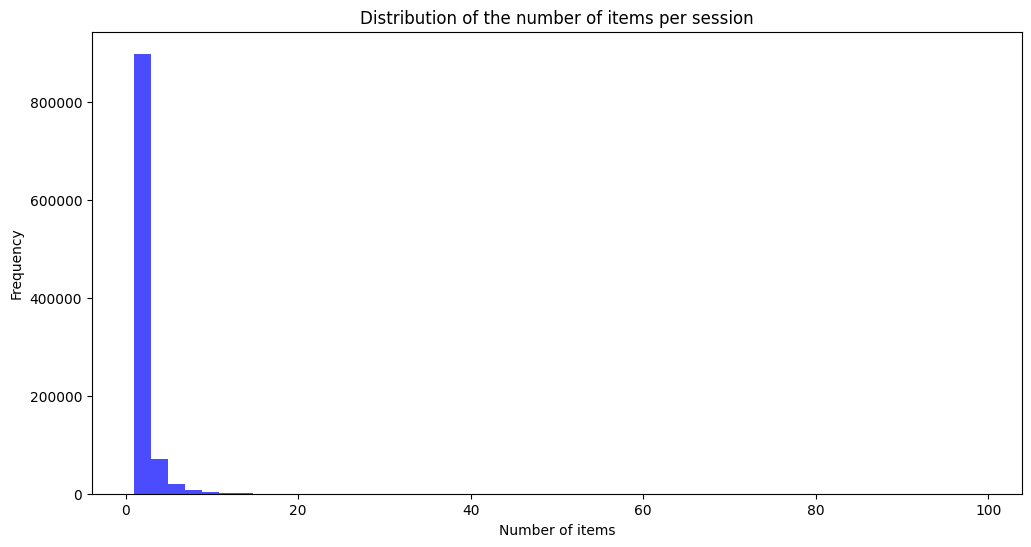

In [ ]:
plt.figure(figsize=(12, 6))
# Set the title of the plot
plt.title('Distribution of the number of items per session')
# Set the x and y labels
plt.xlabel('Number of items')
plt.ylabel('Frequency')
# Create the histogram
plt.hist(df_exploded_items['item_count'], bins=50, color='blue', alpha=0.7)
# Show the plot
plt.show()

In [ ]:
# work only with the first 1000 sessions of the dataset
#df_exploded_items = df_exploded_items.head(100_000)
#df_exploded_items = df_exploded_items.reset_index(drop=True)
df_exploded_items

,session,items,item_count
0,12899782,1669402,1
0,12899782,1494780,3
0,12899782,1674681,1
0,12899782,602722,1
0,12899782,1596098,1
...,...,...,...
39947,14570515,1210365,1
39947,14570515,1257340,1
39947,14570515,754951,1
39947,14570515,1755952,1


In [ ]:
# transform the itemCount in a float number
#df_exploded_items['item_count'] = df_exploded_items['item_count'].astype(float)

In [ ]:
# use the index of the dataframe as session id
#df_exploded_items['session'] = df_exploded_items.index
df_exploded_items['items'] = df_exploded_items['items'].astype('category')
df_exploded_items


C:\Users\adria\AppData\Local\Temp\ipykernel_57612\3221001277.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exploded_items['session'] = df_exploded_items.index


,session,items,item_count
0,0,1669402,1
0,0,1494780,3
0,0,1674681,1
0,0,602722,1
0,0,1596098,1
...,...,...,...
39947,39947,1210365,1
39947,39947,1257340,1
39947,39947,754951,1
39947,39947,1755952,1


In [ ]:
df_pivot = df_exploded_items.pivot_table(index='session', columns='items', values='item_count', aggfunc='first')
df_pivot

c:\Users\adria\anaconda3\envs\nerfstudio\Lib\site-packages\pandas\core\reshape\reshape.py:143: RuntimeWarning: overflow encountered in scalar multiply
  num_cells = num_rows * num_columns


IndexError: index 1677039286 is out of bounds for axis 0 with size 1677022968

In [ ]:
import numpy as np
import pandas as pd

# Supponiamo che df_pivot sia già stato creato come segue:
# df_pivot = df_exploded_items.pivot_table(index='session', columns='items', values='item_count', aggfunc='sum')
# Per questa implementazione, consideriamo il campo item_count come rating

# Convertiamo il DataFrame in una matrice numpy, mantenendo i NaN per le celle mancanti
R_df = df_pivot.copy()
# Creiamo una maschera: 1 per gli elementi osservati, 0 altrimenti
mask = (~R_df.isna()).astype(float).values

# Sostituiamo i NaN in R con 0 (non verranno usati nel calcolo dell'errore grazie alla maschera)
R = R_df.fillna(0).values

def unconstrained_matrix_factorization(R, mask, k=10, epochs=100, alpha=0.001):
    """
    R: matrice dei rating (numpy array) ottenuta dal pivot, con 0 per le celle mancanti
    mask: matrice con 1 per gli elementi osservati e 0 per i mancanti
    k: numero di fattori latenti
    epochs: numero di iterazioni
    alpha: learning rate
    """
    num_users, num_items = R.shape
    # Inizializzazione casuale delle matrici dei fattori
    U = np.random.rand(num_users, k)
    V = np.random.rand(num_items, k)
    
    for epoch in range(epochs):
        # Calcolo delle predizioni
        R_hat = U.dot(V.T)
        # Calcolo dell'errore solo sugli elementi osservati
        error = (R - R_hat) * mask
        # Calcolo della funzione di costo (loss)
        cost = np.sum(error**2) / 2
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, costo: {cost:.4f}")
        # Aggiornamento dei fattori tramite gradient descent
        U_grad = error.dot(V)
        V_grad = error.T.dot(U)
        
        U += alpha * U_grad
        V += alpha * V_grad
    
    return U, V

# Eseguiamo la fattorizzazione
k = 10         # ad esempio, 10 fattori latenti
epochs = 100   # numero di iterazioni
alpha = 0.001  # learning rate

U, V = unconstrained_matrix_factorization(R, mask, k=k, epochs=epochs, alpha=alpha)

# Una volta appresi U e V, la matrice dei rating completa è data da:
R_complete = U.dot(V.T)

# Ad esempio, per predire il rating (item_count) della sessione 0 sull'item con indice 5:
predicted_rating = R_complete[0, 5]
print(f"Predicted rating per sessione 0, item 5: {predicted_rating:.4f}")


MemoryError: Unable to allocate 13.6 GiB for an array with shape (65189, 27981) and data type float64